# 移动通信作业一
### Cell Group Decoupling Analysis of a Dynamic Channel Assignment Strategy in Linear Microcellular Radio Systems 仿真
通信工程 201180104 李水仙

## 一、概述
本次实验基于论文《Cell Group Decoupling Analysis of a Dynamic Channel Assignment Strategy in Linear Microcellular Radio Systems》，仿真实现论文中figure 3、4和5的内容。实验中的主要实现内容包括FCA的理论分析下的阻塞率与load的关系，DBCL的理论分析和实验仿真。最终的仿真图像与论文基本一致，需要注意figure 5中论文的图例标注可能有误。

代码为DBCL.ipynb，自上而下运行code cell，在画图的部分需要运行较长时间（一个约code cell约20分钟）。为了快速得到图像，可以采用见效parameters部分的times_interval，更改为1e5可将画图时间缩短为约10分钟。
## 二、实验原理
### 2.1 FCA
FCA指固定信道分配，每个单元被预先分配一组频率信道。不论单元中的客户数量如何，单元中的信道都保持恒定。这会在一些单元的流量拥挤而其他单元中有空闲容量时出现流量堵塞和一些调用丢失。

FCA分配方式简单，在蜂窝系统话务量均匀分布的情况下，FCA的总阻塞概率和小区中的呼叫阻塞概率相等的，每个小区中的呼叫阻塞概率可以由爱尔兰厄兰公式计算得到：

 $ P_ {B} $ = $ \frac {A^ {N}/N!}{\sum _ {n=0}^ {N}A^ {n}/n!} $ 

N 表示小区有效信道的数量，A 表示流量密度，定义为每单位时间内叫的平均数量,乘以平均呼叫长度，令 $\lambda$ 为每单位时间内的平均呼叫数量，$1/\mu$ 是平均呼叫长度， $A= \lambda  /  \mu $ 。

系统话务量分布不均匀时，信道均匀分配可能会带来高话务量小区阻塞率高、低话务量小区信道资源浪费的情况。

### 2.2 DBCL
DBCL指定向信道锁定的信道借用，整个方案主要由3 个特征定义:锁定方向的确定、信道排序和信道立即重分配。在信道排序中每个小区分配的信道被标号。标号最小的信道具有分配给下一个本地呼叫的最高优先分配权,标号最大的信道则将最先借给临近小区。本地呼叫将从最低标号开始依次分配；借取信道则从最大标号开始依次减小。信道立即重分配是一种将本小区中通话信道和借取信道紧密排列的策略,包括 4个部分:
1. 本地通话排序整理，当其中一个信道的通话结束,而在较高序号的信道中有通话进行,则将后者移至刚释放的序号较低的信道。
2. 当一个利用本地信道的通话结束,同时有一个利用借取信道的通话正在进行,后者将被移至本地信道,借用的信道将被释放。
3. 借用信道排序整理，当其中一个借用信道的通话结束并释放一个借用信道时若此时在较低序号的借用信道中有通话进行,则将后者移至刚释放的序号较高的借用信道。
4. 若在一个干扰小区中某个通话结束信道锁定解除,任何在借取信道或较高序号的信道中进行的通话将切换至该信道。性能研究表明这种方案在适度的负载下性能优于固定信道分配也如期望的那样，比不使用定向锁定的方案性能要有所改善。

## 三、实验部分
### 3.1 基本库的导入


In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from typing import List, Optional

### 3.2 参数的设置
lam0、lams0 为每单位时间内的平均呼叫数量\
1/mu 为平均呼叫长度\
num_cells 为小区的数量\
num_channels 为通道的数量\
start_point、end_point、step 指增加负荷时从(1+start_point)增加至(1+end_point)，步长为step\
times_interval、interval 为仿真时时间间隔的次数与时间间隔的大小。

针对仿真时间间隔，为简化思考，我们认为在一个极短时间内仅有一个呼入或呼出。因此我们设置max(lam0*1.5,lams0*1.5，num_channels*mu)*interval<0.05，因此取interval的大小为1e-3。

针对仿真次数，仿真的次数越多，获得的曲线越平滑，但是由于运算时间的限制，本次实验中取times_interval为1e6.在figure5中，发现仍有较大波动，若时间充足，可进一步扩大times_interval，获得更优曲线。

In [19]:
# parameters
mu=1/3
lam0=100/60
lams0_h=[120, 100, 80, 80, 90, 100, 90, 130, 120, 60, 40, 60, 80, 100, 80, 120, 100, 60, 60, 80,120, 100, 80, 60, 60, 80, 100, 100, 80, 120]
lams0=[i/60 for i in lams0_h]
num_cells=30
num_channels=20
step=0.05
start_point=0
end_point=0.5+step
times_interval=1e6
interval=1e-3

### 3.3 小区的表示
本次实验中考虑单个小区和整个小区，Cell表示单个小区，保存了本身的通话负荷，是否有左右邻居的信息。Cells表示最基本的所有小区的信息，包含所有小区的列表，可以进行负载的更新。

In [3]:
# calculate A
def cal_A(lam):
    return lam/mu

class Cell():
    '''
    this class denote a single cell, which include the info of its load and whether has neighbors.
    '''
    def __init__(self,lam,left=True,right=True):
        '''
        left denotes whether the cell has left neighbor
        right denotes whether the cell has right neighbor
        '''
        self.lam=lam
        self.left_cell=left
        self.right_cell=right
        self.a=cal_A(self.lam)

    def update_edge(self,mode):
        '''
        If the cell is on the edge, set the coresponding edge bool Fasle.
        '''
        if mode==0:
            self.left_cell=False
        elif mode==1:
            self.right_cell=False
    
    def update_a_times(self,increase):
        self.lam*=(1+increase)
        self.a=cal_A(self.lam)

    def update_a(self, lam):
        self.lam=lam
        self.a=cal_A(self.lam)

class Cells():
    '''
    this class denote a bunch of cells and includes the info of the number of cells and channels. It can update the load.
    '''
    def __init__(self,lams,num_channels):
        self.lams0=lams
        self.list_cell=[Cell(lam) for lam in lams]
        self.list_cell[0].update_edge(0)
        self.list_cell[-1].update_edge(1)
        self.num_channels=num_channels

    def back_original_loads(self):
        for index in range(len(self.list_cell)):
            self.list_cell[index].update_a(self.lams0[index])

    def update_loads(self,increase):
        self.back_original_loads()
        for cell in self.list_cell:
            cell.update_a_times(increase)
    

### 3.4 FCA Analyze
FCA的单个小区阻塞概率的计算公式为 $ P_ {B} $ = $ \frac {A^ {N}/N!}{\sum _ {n=0}^ {N}A^ {n}/n!} $ ，总阻塞概率为各个小区的阻塞概率的加权平均。

In [4]:
# sample
load_increase=np.arange(start_point,end_point,step)

class Cells_FCA(Cells):
    def __init__(self,lams,num_channels):
        super().__init__(lams,num_channels)
        self.num_channels//=2

    def cal_sub_Bi(self,cell:Cell,n):
        return cell.a**n/math.factorial(n)
    
    def cal_Bi(self,cell:Cell):
        return self.cal_sub_Bi(cell,self.num_channels)/sum([self.cal_sub_Bi(cell,i) for i in range(0,self.num_channels+1)])
    
    def cal_B(self):
        return sum([self.cal_Bi(i)*i.lam for i in self.list_cell])/sum([i.lam for i in self.list_cell])

### 3.5 BDCL Analyze
BDCL单个小区的计算公式为 <img src='Screenshot 2024-04-28 at 23.47.01.png' width=30%>\
平均阻塞概率为加权平均 <img src='Screenshot 2024-04-28 at 23.45.52.png' width=30%>\

In [5]:
# analyze
class Cells_BDCL(Cells):
    def __init__(self,lams,num_channels):
        super().__init__(lams,num_channels)
        
    def cal_G(self,three_cells:List[Cell]):
        g=0
        if len(three_cells) == 2 and three_cells[0].left_cell==False:
            # left edge
            for x1 in range(0,self.num_channels+1):
                for x2 in range(0,self.num_channels+1-x1):
                    g+=three_cells[0].a**x1/math.factorial(x1)*three_cells[1].a**x2/math.factorial(x2)
            return g
        if len(three_cells) == 2 and three_cells[1].right_cell==False:
            # right edge
            for x1 in range(0,self.num_channels+1):
                for x3 in range(0,self.num_channels+1-x1):
                    g+=three_cells[0].a**x3/math.factorial(x3)*three_cells[1].a**x1/math.factorial(x1)
            return g
        if len(three_cells) == 3:
            for x1 in range(0,self.num_channels+1):
                for x2 in range(0,self.num_channels+1-x1):
                    for x3 in range(0,self.num_channels+1-x1):
                        g+=three_cells[0].a**x3/math.factorial(x3)*three_cells[1].a**x1/math.factorial(x1)*three_cells[2].a**x2/math.factorial(x2)
            return g
        return None
    
    def cal_P(self,three_cells:List[Cell],x_list:list):
        if len(three_cells) == 2 and three_cells[0].left_cell==False:
            # left edge
            x1=x_list[0]
            x2=x_list[1]
            return three_cells[0].a**x1/math.factorial(x1)* three_cells[1].a**x2/math.factorial(x2)/self.cal_G(three_cells)
        if len(three_cells) == 2 and three_cells[1].right_cell==False:
            # right edge
            x1=x_list[0]
            x3=x_list[1]
            return three_cells[0].a**x3/math.factorial(x3)* three_cells[1].a**x1/math.factorial(x1)/self.cal_G(three_cells)
        if len(three_cells) == 3:
            x1=x_list[0]
            x2=x_list[1]
            x3=x_list[2]
            return three_cells[0].a**x3/math.factorial(x3)* three_cells[1].a**x1/math.factorial(x1)*three_cells[2].a**x2/math.factorial(x2)/self.cal_G(three_cells)

    def cal_Bi(self,three_cells:List[Cell]):
        bi=0
        if len(three_cells) == 2 and (three_cells[0].left_cell==False or three_cells[1].right_cell==False):
            # left edge x3=0 or right edge x2=0
            for x1 in range(0,self.num_channels+1):
                bi+=self.cal_P(three_cells,[x1,self.num_channels-x1])
            return bi
        if len(three_cells) == 3:
            for x1 in range(0,self.num_channels+1):
                for x3 in range(0,self.num_channels+1-x1):
                    bi+=self.cal_P(three_cells,[x1,self.num_channels-x1,x3])
            for x1 in range(0,self.num_channels):
                for x2 in range(0,self.num_channels-x1):
                    bi+=self.cal_P(three_cells,[x1,x2,self.num_channels-x1])
            return bi
        
    def cal_B(self):
        b=0
        sum_lam=0
        for index in range(len(self.list_cell)):
            lam=self.list_cell[index].lam
            if index==0:
                three_cells=self.list_cell[index:index+2]
            elif index==len(self.list_cell)-1:
                three_cells=self.list_cell[index-1:index+1]
            else:
                three_cells=self.list_cell[index-1:index+2]
            sum_lam+=lam
            b+=lam*self.cal_Bi(three_cells)
        return b/sum_lam


### 3.7 BDCL Simulation
针对BDCL仿真，更新Cell_simul和Cells_simul的定义。单位时间的通话数量负荷泊松分布，因此lam * interval > random.uniform(0,1)表示有一个呼入，num_use_channel*mu * interval > random.uniform(0,1)表示有一个呼出。

In [6]:
# simul
class Cell_simul(Cell):
    def __init__(self,lam,num_channels,left=True,right=True,mode='A'):
        super().__init__(lam,left,right)
        if mode=='A':
            self.mode_channel=[1]*(num_channels//2)+[0]*(num_channels-num_channels//2)
        else:
            self.mode_channel=[0]*(num_channels//2)+[1]*(num_channels-num_channels//2)
        self.num_call=0
        self.num_block=0
        self.use_channel=[0]*num_channels
        self.num_channels=num_channels

    def check_available_channel_from_small(self)->Optional[int]:
        for i in range(self.num_channels):
            if self.mode_channel[i]==1 and self.use_channel[i]==0:
                return i
        return None
    
    def check_available_channel_from_big(self)->Optional[int]:
        for i in range(self.num_channels-1,-1,-1):
            if self.mode_channel[i]==1 and self.use_channel[i]==0:
                return i
        return None
    
    def check_using_channel_from_big(self)->Optional[int]:
        for i in range(self.num_channels-1,-1,-1):
            if self.mode_channel[i]==2:
                return i
        for i in range(self.num_channels-1,-1,-1):
            if (self.mode_channel[i]==1 and self.use_channel[i]==1):
                return i
        return None
    
class Cells_simul():
    '''
    this class denote a bunch of cells and includes the info of the number of cells and channels. It can update the load.
    '''
    def __init__(self,lams,num_channels):
        self.lams0=lams
        modes=['A','B']
        self.list_cell=[Cell_simul(lams[index],num_channels,mode=modes[index%2]) for index in range(len(lams))]
        self.list_cell[0].update_edge(0)
        self.list_cell[-1].update_edge(1)
        self.num_channels=num_channels
    def clear_block(self):
        for cell in self.list_cell:
            cell.num_block=0
            cell.num_call=0

    def back_original_loads(self):
        for index in range(len(self.list_cell)):
            self.list_cell[index].update_a(self.lams0[index])

    def update_loads(self,increase):
        self.back_original_loads()
        for cell in self.list_cell:
            cell.update_a_times(increase)
            
    def find_spare_channel(self,cells_neighbor:List[Cell_simul])->Optional[int]:
        '''
        when there is a call in, find the channel to allocate
        '''
        if len(cells_neighbor)==1:
            return cells_neighbor[0].check_available_channel_from_big()
        elif len(cells_neighbor)==2:
            for i in range(cells_neighbor[0].num_channels-1,-1,-1):
                if cells_neighbor[0].mode_channel[i]==1 and cells_neighbor[1].mode_channel[i]==1 and cells_neighbor[0].use_channel[i]==0 and cells_neighbor[1].use_channel[i]==0:
                    return i
        return None
        
    def allocate_channel(self,cell_allocate:Cell_simul,cells_neighbor:List[Cell_simul]):
        channel=cell_allocate.check_available_channel_from_small()
        if isinstance(channel,int):
            cell_allocate.use_channel[channel]=1
            return channel
        else:
            channel=self.find_spare_channel(cells_neighbor)
            if isinstance(channel,int):
                cell_allocate.mode_channel[channel]=2
                cell_allocate.use_channel[channel]=1
                for cell in cells_neighbor:
                    cell.mode_channel[channel]=3
                return channel
            else:
                return None

    def release_channel(self,cell_allocate:Cell_simul,cells_neighbor:List[Cell_simul],channel):
        '''
        if there is a call ending. release from mode 2
        '''
        if cell_allocate.mode_channel[channel]==1:
            cell_allocate.use_channel[channel]=0
        elif cell_allocate.mode_channel[channel]==2:
            cell_allocate.mode_channel[channel]=0
            cell_allocate.use_channel[channel]=0
            for cell in cells_neighbor:
                cell.mode_channel[channel]=1
                cell.use_channel[channel]=0

    def simul_one_time(self,interval):
        for index in range(len(self.list_cell)):
            lam=self.list_cell[index].lam
            cell_allocate=self.list_cell[index]
            cells_neighbor=[]
            if index!=0:
                cells_neighbor.append(self.list_cell[index-1])
            if index!=(len(self.list_cell)-1):
                cells_neighbor.append(self.list_cell[index+1])

            if lam * interval > random.uniform(0,1):
                # call in
                channel=self.allocate_channel(cell_allocate,cells_neighbor)
                cell_allocate.num_call+=1
                if not isinstance(channel,int):     
                    cell_allocate.num_block+=1
            channel=cell_allocate.check_using_channel_from_big()

            if  isinstance(channel,int) and (sum(cell_allocate.use_channel)*mu * interval) > random.uniform(0,1):
                # call end
                self.release_channel(cell_allocate,cells_neighbor,channel)
            
    def simul_B(self,times,interval):
        for i in range(int(times)):
            # print('-'*10+str(i)+'-'*10)
            self.simul_one_time(interval)
        lams=[]
        ave_B=0
        for cell in self.list_cell:
            lam=cell.lam
            lams.append(lam)
            block=cell.num_block/cell.num_call
            ave_B+=lam*block
        return ave_B/sum(lams)

    def simul_Bi(self,times,interval,indexes):
        for i in range(int(times)):
            # print('-'*10+str(i)+'-'*10)
            self.simul_one_time(interval)
        lams=[]
        blocks=[]
        for index in indexes:
            cell=self.list_cell[index]
            lam=cell.lam
            lams.append(lam)
            block=cell.num_block/cell.num_call
            blocks.append(block)
        return blocks

## 四、实验结果
### figure 3 Linear microcellular network with uniform traffic distribution.

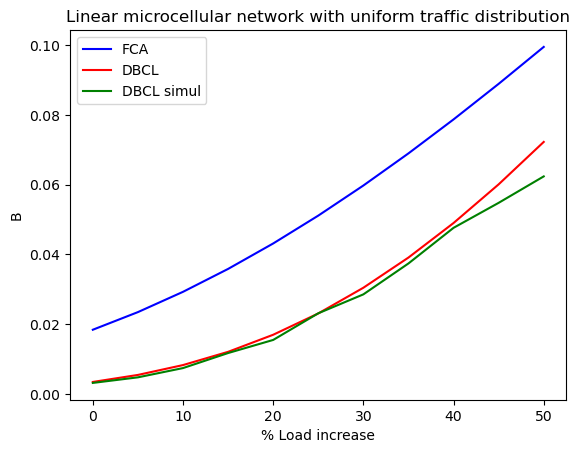

In [7]:
# # Linear microcellular network with uniform traffic distribution
# For FCA
fca_uniform=Cells_FCA([lam0]*num_cells,num_channels)
b_fca_uniform=[]
for i in load_increase:
    fca_uniform.update_loads(i)
    b_fca_uniform.append(fca_uniform.cal_B())
plt.plot(load_increase*100, b_fca_uniform,'b-', label='FCA')

# For BDCL
bdcl_uniform=Cells_BDCL([lam0]*num_cells,num_channels)
b_bdcl_uniform=[]
for i in load_increase:
    bdcl_uniform.update_loads(i)
    b_bdcl_uniform.append(bdcl_uniform.cal_B())
plt.plot(load_increase*100, b_bdcl_uniform, 'r-', label='DBCL')

# For BDCL simul
bdcl_uniform_simul=Cells_simul([lam0]*num_cells,num_channels)
b_bdcl_unifor_simul=[]
for i in load_increase:
    bdcl_uniform_simul.update_loads(i)
    b_bdcl_unifor_simul.append(bdcl_uniform_simul.simul_B(times_interval,interval))
    bdcl_uniform_simul.clear_block()
plt.plot(load_increase*100, b_bdcl_unifor_simul, 'g-', label='DBCL simul')

# figure 3
plt.xlabel(r'% Load increase')
plt.ylabel('B')
plt.title('Linear microcellular network with uniform traffic distribution')
plt.legend()
plt.show()

### figure 4 Linear microcellular network with nonuniform traffic distribution.

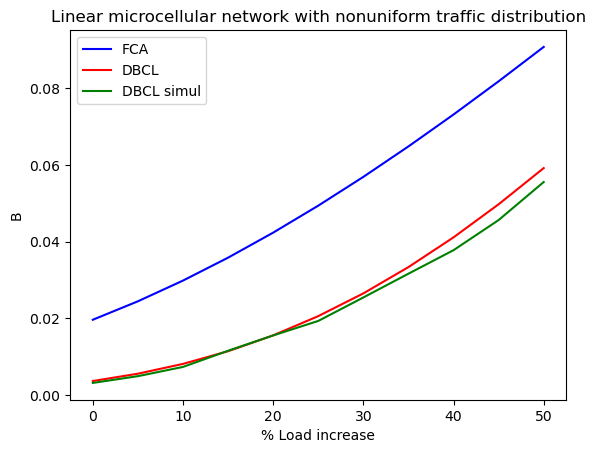

In [16]:
# Linear microcellular network with nonuniform traffic distribution
# For FCA
fca_nonuniform=Cells_FCA(lams0,num_channels)
b_fca_nonuniform=[]
for i in load_increase:
    fca_nonuniform.update_loads(i)
    b_fca_nonuniform.append(fca_nonuniform.cal_B())
plt.plot(load_increase*100, b_fca_nonuniform,'b-', label='FCA')

# For BDCL
bdcl_nonuniform=Cells_BDCL(lams0,num_channels)
b_bdcl_nonuniform=[]
for i in load_increase:
    bdcl_nonuniform.update_loads(i)
    b_bdcl_nonuniform.append(bdcl_nonuniform.cal_B())
plt.plot(load_increase*100, b_bdcl_nonuniform, 'r-', label='DBCL')

# For BDCL simul
bdcl_nonuniform_simul=Cells_simul(lams0,num_channels)
b_bdcl_nonunifor_simul=[]
for i in load_increase:
    bdcl_nonuniform_simul.update_loads(i)
    b_bdcl_nonunifor_simul.append(bdcl_nonuniform_simul.simul_B(times_interval,interval))
    bdcl_nonuniform_simul.clear_block()
plt.plot(load_increase*100, b_bdcl_nonunifor_simul, 'g-', label='DBCL simul')

# figure 4
plt.xlabel(r'% Load increase')
plt.ylabel('B')
plt.title('Linear microcellular network with nonuniform traffic distribution')
plt.legend()
plt.show()

### figure 5 Boundary cells of a linear network with non-uniform traffic

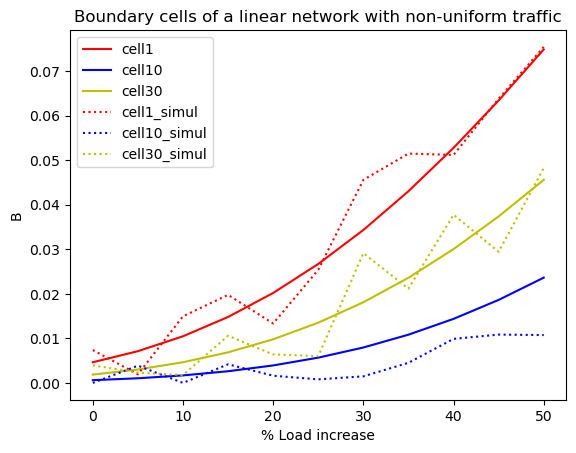

In [22]:
# Boundary cells of a linear network with non-uniform traffic.
# analyse
b_cell1=[]
b_cell10=[]
b_cell30=[]
for i in load_increase:
    bdcl_nonuniform.update_loads(i)
    b_cell1.append(bdcl_nonuniform.cal_Bi(bdcl_nonuniform.list_cell[:2]))
    b_cell10.append(bdcl_nonuniform.cal_Bi(bdcl_nonuniform.list_cell[8:11]))
    b_cell30.append(bdcl_nonuniform.cal_Bi(bdcl_nonuniform.list_cell[28:30]))

plt.plot(load_increase*100, b_cell1, 'r-', label='cell1')
plt.plot(load_increase*100, b_cell10, 'b-', label='cell10')
plt.plot(load_increase*100, b_cell30, 'y-', label='cell30')

# simul
b_cell1_simul=[]
b_cell10_simul=[]
b_cell30_simul=[]
for i in load_increase:
    print(i)
    bdcl_nonuniform_simul.update_loads(i)
    blocks=bdcl_nonuniform_simul.simul_Bi(times_interval,interval,[0,9,29])
    b_cell1_simul.append(blocks[0])
    b_cell10_simul.append(blocks[1])
    b_cell30_simul.append(blocks[2])
    bdcl_nonuniform_simul.clear_block()

plt.plot(load_increase*100, b_cell1_simul, 'r:', label='cell1_simul')
plt.plot(load_increase*100, b_cell10_simul, 'b:', label='cell10_simul')
plt.plot(load_increase*100, b_cell30_simul, 'y:', label='cell30_simul')

# figure 5
plt.xlabel(r'% Load increase')
plt.ylabel('B')
plt.title('Boundary cells of a linear network with non-uniform traffic')
plt.legend()
plt.show()